# Computer Vision

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Findings" data-toc-modified-id="Findings-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Findings</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Prepare-the-Script-to-Run-on-the-GPU-Platform" data-toc-modified-id="Prepare-the-Script-to-Run-on-the-GPU-Platform-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Prepare the Script to Run on the GPU Platform</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Output</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

## Initialization

In [15]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [16]:
SEED=12

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [17]:
#================================================================================
#check nulls

def missing_values(data):
    miss_values = data.isnull().sum().to_frame()
    miss_values = miss_values.rename(columns = {0: 'missing_values'})
    miss_values['%_of_total'] = ((miss_values['missing_values'] / data.shape[0]) *100).round(2)
    display(miss_values)

#================================================================================

In [18]:
#labels
labels = pd.read_csv('/datasets/faces/labels.csv')

In [19]:


missing_values(labels)
# find duplicates
labels.duplicated().sum()

# show dataframe info
display(labels.info())

labels['real_age'].value_counts()

,missing_values,%_of_total
file_name,0,0.0
real_age,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

## EDA

min: 1
max: 100


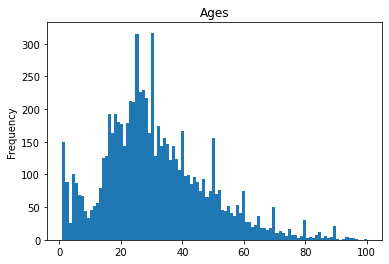

In [20]:
print('min:', labels['real_age'].min())
print('max:', labels['real_age'].max())

labels['real_age'].plot(title='Ages', kind='hist', bins=100, range=(labels['real_age'].min(), labels['real_age'].max()))
plt.show()

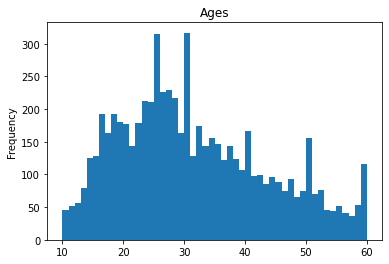

In [21]:
labels['real_age'].plot(title='Ages', kind='hist', bins=50, range=(10, 60))
plt.show()

Found 7591 validated image filenames.


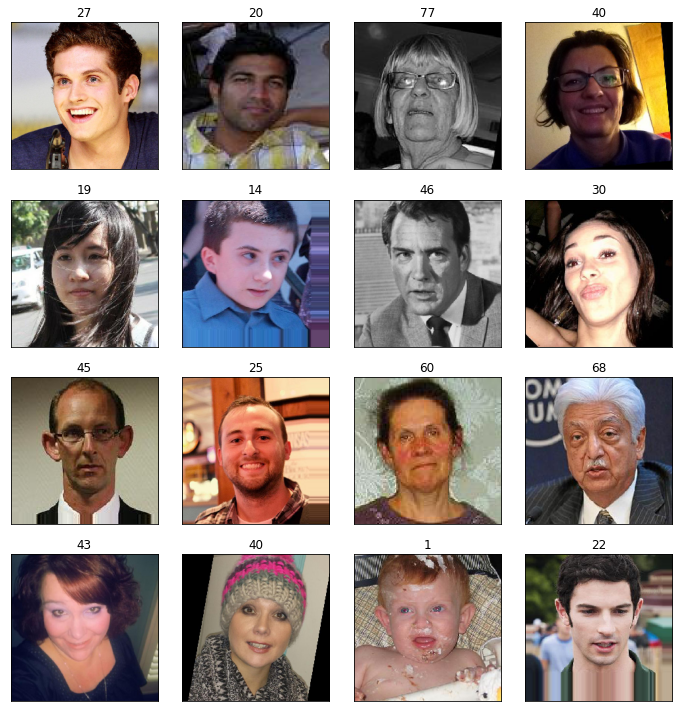

In [29]:
# data generator
datagen = ImageDataGenerator(rescale=1/255)
datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
#    subset='training',
    seed=SEED,
)



features, target = next(datagen_flow)

# display 16 images
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout() 

### Findings

* The ages vary from 0 to 100.
* The majority of the photos are of ages 20-30.
* Around age 18 there are less than 200 photos per age.
###### problems:
* The main problem is to distinguish between teenagers from adults. There's no way to know from a photo if a person is a month under 18 or a day over 18.
* In most cases the pictures are of smiling people. Usually, when people are buying, they don't smile like when taking a picture. It may affect the wrinkles.
* Light conditions.
* Objects that hide the face (e.g glasses).
* Rotated pictures and angle of photography.
* Quality of photograph, makeup, beard etc.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [23]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [24]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=SEED,
    )

    return train_datagen_flow


In [25]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=SEED,
    ) 

    return test_datagen_flow

In [26]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    
    model = Sequential()
    model.add(backbone)    
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0004), 
                  metrics=['mean_absolute_error'])
    print(model.summary())
    
    return model

In [27]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(
        train_data, 
        validation_data=test_data, 
        batch_size=batch_size, 
        epochs=epochs, 
        steps_per_epoch=steps_per_epoch, 
        validation_steps=validation_steps, 
        verbose=2
    ) 

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [28]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

SEED=12
tf.random.set_seed(SEED)
#labels
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale= 1/255, validation_split=0.25)
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

2022-08-02 10:58:28.715014: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-08-02 10:58:28.923482: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-08-02 10:58:34.265782: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-02 10:58:34.939780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-02 10:58:34.939849: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-02 10:58:34.939881: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-02 10:58:35.037399: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-02 10:58:35.052474: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-02 10:58:35.392980: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-02 10:58:35.414476: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-02 10:58:35.414586: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-02 10:58:35.419120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-08-02 10:58:35.419527: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-08-02 10:58:35.458829: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2022-08-02 10:58:35.461886: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4eb9970 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-02 10:58:35.461916: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-02 10:58:35.694612: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556f9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-02 10:58:35.694656: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-08-02 10:58:35.697103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-02 10:58:35.697163: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-02 10:58:35.697173: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-02 10:58:35.697203: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-02 10:58:35.697212: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-02 10:58:35.697223: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-02 10:58:35.697231: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-02 10:58:35.697238: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-02 10:58:35.701645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-08-02 10:58:35.703940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-02 10:58:39.066209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-08-02 10:58:39.066262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-08-02 10:58:39.066270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-08-02 10:58:39.072427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2022-08-02 10:59:04.199558: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-02 10:59:06.468335: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 71s - loss: 194.1369 - mean_absolute_error: 10.3539 - val_loss: 634.0634 - val_mean_absolute_error: 20.2718
Epoch 2/20
178/178 - 38s - loss: 90.4088 - mean_absolute_error: 7.2498 - val_loss: 687.9316 - val_mean_absolute_error: 21.3401
Epoch 3/20
178/178 - 37s - loss: 51.9593 - mean_absolute_error: 5.5047 - val_loss: 510.0174 - val_mean_absolute_error: 17.6017
Epoch 4/20
178/178 - 38s - loss: 38.0160 - mean_absolute_error: 4.7676 - val_loss: 160.3628 - val_mean_absolute_error: 9.8634
Epoch 5/20
178/178 - 37s - loss: 26.7043 - mean_absolute_error: 3.9962 - val_loss: 84.8764 - val_mean_absolute_error: 6.9906
Epoch 6/20
178/178 - 37s - loss: 18.1650 - mean_absolute_error: 3.2667 - val_loss: 78.2306 - val_mean_absolute_error: 6.7146
Epoch 7/20
178/178 - 38s - loss: 14.1828 - mean_absolute_error: 2.8734 - val_loss: 75.3887 - val_mean_absolute_error: 6.5302
Epoch 8/20
178/178 - 37s - loss: 11.4744 - mean_absolute_error: 2.5948 - val_loss: 84.5973 - val_mean_absolute_error: 6.8915
Epoch 9/20
178/178 - 38s - loss: 9.1456 - mean_absolute_error: 2.3282 - val_loss: 69.5171 - val_mean_absolute_error: 6.4664
Epoch 10/20
178/178 - 38s - loss: 8.1439 - mean_absolute_error: 2.1779 - val_loss: 71.4067 - val_mean_absolute_error: 6.4941
Epoch 11/20
178/178 - 37s - loss: 7.8399 - mean_absolute_error: 2.1245 - val_loss: 68.3744 - val_mean_absolute_error: 6.2065
Epoch 12/20
178/178 - 37s - loss: 7.9328 - mean_absolute_error: 2.1490 - val_loss: 76.9009 - val_mean_absolute_error: 6.6276
Epoch 13/20
178/178 - 37s - loss: 7.5118 - mean_absolute_error: 2.0739 - val_loss: 76.8396 - val_mean_absolute_error: 6.8563
Epoch 14/20
178/178 - 37s - loss: 7.7052 - mean_absolute_error: 2.1040 - val_loss: 69.4359 - val_mean_absolute_error: 6.1780
Epoch 15/20
178/178 - 38s - loss: 8.0684 - mean_absolute_error: 2.1567 - val_loss: 69.5903 - val_mean_absolute_error: 6.2280
Epoch 16/20
178/178 - 37s - loss: 9.0217 - mean_absolute_error: 2.2976 - val_loss: 70.3049 - val_mean_absolute_error: 6.2883
Epoch 17/20
178/178 - 37s - loss: 9.7302 - mean_absolute_error: 2.3781 - val_loss: 68.5800 - val_mean_absolute_error: 6.2408
Epoch 18/20
178/178 - 37s - loss: 10.6978 - mean_absolute_error: 2.4717 - val_loss: 85.2506 - val_mean_absolute_error: 6.7426
Epoch 19/20
178/178 - 37s - loss: 12.4808 - mean_absolute_error: 2.6988 - val_loss: 74.5769 - val_mean_absolute_error: 6.4339
Epoch 20/20
178/178 - 38s - loss: 14.5084 - mean_absolute_error: 2.9217 - val_loss: 94.1662 - val_mean_absolute_error: 7.5717
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 94.1662 - mean_absolute_error: 7.5717
Test MAE: 7.5717

## Conclusions

1. A photograph cannot predict the exact age in years (and definitely in days).
2. The average error in this execution is about 7.5 years. So, in order to be on the safe side, people who look younger than 26, should be asked to show an ID as a proof. 
3. As there are teenagers who want to look older, and adults who look or try to look younger, it can be very difficult to know the exact age.
4. This system can also be useful for senior or disabled (like blinds) people - to be offered help.
5. It can be also useful for offering pruducts for different ages (In personal, I don't like being offered other products when I'm already in the cash, and want to finish shopping).
